In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from xgboost import plot_importance
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import KFold
from hyperopt import fmin, tpe, Trials
from hyperopt import hp

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import time

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import scipy.stats as stats


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# 데이터 로딩 df로 저장
cust_df=pd.read_csv('./santander-customer-satisfaction/train.csv')
print(cust_df.shape) # (76020, 371)

(76020, 371)


In [3]:
cust_df.head(3) 

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [4]:
cust_df.info()  # 문자열 없음. 범주형을 숫자로 바꿀필요는 없는듯

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [5]:
# 불균형 여부 확인 (label)
cust_cnt = cust_df['TARGET'].value_counts()  # 값을 체크 (0:  73012, 1: 3008)
print(cust_cnt)


TARGET
0    73012
1     3008
Name: count, dtype: int64


In [6]:
cust_rate= cust_cnt[1] / cust_cnt.sum()  # 두개 합친값

print(f'{cust_rate:.2f}') # 불만족 고객 비율 0.04

0.04


In [7]:
# 데이터 통계 확인 : 피처들간의 값 차이가 많이난다. 최대최소값이 너무 많이나는거 있음. 
# not null 걸어두면 의미없는 작은값을 배당= -99999.. 된곳이 이렇게 된거일수 있다고 추축됨
cust_df.describe()  

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [8]:
# var3 -999999가 몇개인지 확인 
print(cust_df['var3'].value_counts())  # 가장 많은 순으로 출력 

var3
 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 63            1
 194           1
 40            1
 57            1
 87            1
Name: count, Length: 208, dtype: int64


In [9]:
# -999999 =NaN  --> 가장많은 값 2로 변경
cust_df['var3'].replace(-999999, 2, inplace=True) 

# id는 일련번호로 의미가 없으므로 삭제
cust_df.drop('ID', axis=1, inplace=True)  # axis=1은 열삭제 

In [10]:
# 데이터 분리
X_features = cust_df.iloc[:, :-1]  # 마지막 열을 제외한 모든 열
y_labels = cust_df.loc[:, 'TARGET']  # 마지막 열만 선택, 네임드인덱스로 가져옴

print(f'전체 데이터 구조: {X_features.shape}')
# 전체 데이터 구조: (76020, 369)  : id빼고 답제외

전체 데이터 구조: (76020, 369)


In [11]:
print(cust_df['var3'].value_counts())

var3
2      74281
8        138
9        110
3        108
1        105
       ...  
63         1
194        1
40         1
57         1
87         1
Name: count, Length: 207, dtype: int64


In [12]:
# 학습, 테스트용 분리

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=0)

# 학습, 테스트 (label)데이터의 균형성 확인 
# 각 (label)데이터의 개수 저장

train_cnt = y_train.count() # 학습데이터 레이블의 갯수 - 분포를 보려고 변수에 저장해둠
test_cnt = y_test.count() # 테스트데이터 레이블의 갯수

print(f'학습데이터 구조: {X_train.shape}, \n테스트데이터의 구조: {X_test.shape}')
# print(f'학습데이터 레이블의 갯수: {train_cnt}')
# print(f'테스트데이터 레이블의 갯수: {test_cnt}') 

학습데이터 구조: (60816, 369), 
테스트데이터의 구조: (15204, 369)


In [13]:
print('학습 레이블 값 분포 비율', y_train.value_counts() /train_cnt)  # train 레이블의 비율 271p
print('테스트 레이블 값 분포 비율', y_test.value_counts() /test_cnt)  # test 레이블의 비율

# 둘다 4%정도 비율로 비슷함

학습 레이블 값 분포 비율 TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64
테스트 레이블 값 분포 비율 TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


In [14]:
# 학습 검증세트로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)



### XGBoost

In [15]:
# XGBoost: base 모델의 성능 확인

xgb_clf=XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    early_stopping=100, # 조기 종료:100번 동안 성능 개선이 없다면 종료
    eval_metric='auc', # 평가 지표: auc
    random_state=156
)

xgb_clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)]) # 검증 데이터 설정[(검증데이터, 검증답)]해서 학습 

[0]	validation_0-auc:0.81454
[1]	validation_0-auc:0.81613
[2]	validation_0-auc:0.81844
[3]	validation_0-auc:0.81988
[4]	validation_0-auc:0.82153
[5]	validation_0-auc:0.82355
[6]	validation_0-auc:0.82479
[7]	validation_0-auc:0.82580
[8]	validation_0-auc:0.82608


c:\Users\choco\.conda\envs\pyml\lib\site-packages\xgboost\training.py:183: UserWarning: [18:03:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "early_stopping" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[9]	validation_0-auc:0.82734
[10]	validation_0-auc:0.82816
[11]	validation_0-auc:0.82862
[12]	validation_0-auc:0.82971
[13]	validation_0-auc:0.83028
[14]	validation_0-auc:0.83086
[15]	validation_0-auc:0.83148
[16]	validation_0-auc:0.83203
[17]	validation_0-auc:0.83223
[18]	validation_0-auc:0.83232
[19]	validation_0-auc:0.83247
[20]	validation_0-auc:0.83260
[21]	validation_0-auc:0.83269
[22]	validation_0-auc:0.83282
[23]	validation_0-auc:0.83296
[24]	validation_0-auc:0.83302
[25]	validation_0-auc:0.83268
[26]	validation_0-auc:0.83240
[27]	validation_0-auc:0.83253
[28]	validation_0-auc:0.83274
[29]	validation_0-auc:0.83227
[30]	validation_0-auc:0.83244
[31]	validation_0-auc:0.83287
[32]	validation_0-auc:0.83286
[33]	validation_0-auc:0.83314
[34]	validation_0-auc:0.83300
[35]	validation_0-auc:0.83302
[36]	validation_0-auc:0.83352
[37]	validation_0-auc:0.83332
[38]	validation_0-auc:0.83339
[39]	validation_0-auc:0.83348
[40]	validation_0-auc:0.83351
[41]	validation_0-auc:0.83357
[42]	valida

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping=100,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, ...)

In [16]:
#  일반화 AUC성능 확인 : 0.8385 (면적, 1이면 최대)
xgb_roc_auc_score = roc_auc_score(
    y_test, xgb_clf.predict_proba(X_test)[:, 1]  #[:, 0이거나1] > 0:N확률, 1:N 확률 : 확률로 auc 계산
) 
print(f'AUC : {xgb_roc_auc_score:.4f}')  

AUC : 0.8385


In [17]:
# hyperopt, KFold 사용한 튜닝

# 공간지정: 하이퍼옵트의 fmin()에 사용한다. 
# 초기에는 랜덤하게 샘플링, 이후로 탐색공간을 좁혀가며 호율적으로 샘플링한다. 
# max_depth는 5에서 15까지 1간격으로, min_child_weight는 1에서 6까지 1간격으로
# colsample_bytree는 0.5에서 0.95사이, learning_rate는 0.01에서 0.2사이 정규 분포된 값으로 검색.


xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 15, 1),
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
}


In [18]:
# 목적 함수 설정.
# 추후 fmin()에서 입력된 search_space값으로 XGBClassifier 교차 검증 학습 후 -1* roc_auc 평균 값을 반환.  
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=100, # 작게 설정함
                            max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            colsample_bytree=search_space['colsample_bytree'],
                            learning_rate=search_space['learning_rate'],
                            early_stopping_rounds=30,  # early stopping은 30회
                            eval_metric='auc',  # 평가 지표: auc
                            n_jobs=-1,
                            random_state=156
    )
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list= []
   
    # 3개 k-fold방식 적용
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train): # X_train : 6만건
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        # 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행.
        xgb_clf.fit(X_tr, y_tr,eval_set=[(X_tr, y_tr), (X_val, y_val)])
   
        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음.
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score) 
       
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환(AUC평균 점수가 가장 좋을때의 파라미터를 찾기위함)
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
    return -1 * np.mean(roc_auc_list)



In [19]:
trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수: 50회 하이퍼파라미터를 조합해 평가한다. 
            trials=trials, 
            rstate=np.random.default_rng(seed=30)) #fmin의 랜덤시드

print('best: ', best)

[0]	validation_0-auc:0.76337	validation_1-auc:0.72658 
[1]	validation_0-auc:0.83413	validation_1-auc:0.80531 
[2]	validation_0-auc:0.84855	validation_1-auc:0.82068 
[3]	validation_0-auc:0.85373	validation_1-auc:0.82600 
[4]	validation_0-auc:0.85711	validation_1-auc:0.82750 
[5]	validation_0-auc:0.85829	validation_1-auc:0.82702 
[6]	validation_0-auc:0.86189	validation_1-auc:0.82820 
[7]	validation_0-auc:0.86457	validation_1-auc:0.82978 
[8]	validation_0-auc:0.86610	validation_1-auc:0.83008 
[9]	validation_0-auc:0.86667	validation_1-auc:0.83073 
[10]	validation_0-auc:0.86836	validation_1-auc:0.83101
[11]	validation_0-auc:0.86953	validation_1-auc:0.83132
[12]	validation_0-auc:0.87034	validation_1-auc:0.83104
[13]	validation_0-auc:0.87152	validation_1-auc:0.83167
[14]	validation_0-auc:0.87235	validation_1-auc:0.83242
[15]	validation_0-auc:0.87331	validation_1-auc:0.83274
[16]	validation_0-auc:0.87401	validation_1-auc:0.83221
[17]	validation_0-auc:0.87468	validation_1-auc:0.83245
[18]	valid

In [20]:
# best(dict)로 다시 학습 

xgb_clf = XGBClassifier(
    n_estimators=500,
    learning_rate=round(best['learning_rate'], 5), # 소수점 이하 자리 반올림
    max_depth=int(best['max_depth']),
    min_child_weight=int(best['min_child_weight']),
    colsample_bytree=round(best['colsample_bytree'], 5),
    early_stopping_rounds=100,  # 조기종료 
    eval_metric="auc",  # 평가 지표 
    random_state=156,
    n_jobs=-1  
)

# 학습 수행.
xgb_clf.fit(
    X_tr, y_tr,
    eval_set=[(X_tr, y_tr), (X_val, y_val)]
)

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))
#ROC AUC: 0.8385에서

[0]	validation_0-auc:0.74763	validation_1-auc:0.72835
[1]	validation_0-auc:0.82532	validation_1-auc:0.80810
[2]	validation_0-auc:0.83852	validation_1-auc:0.81853
[3]	validation_0-auc:0.84425	validation_1-auc:0.82378
[4]	validation_0-auc:0.84918	validation_1-auc:0.82827
[5]	validation_0-auc:0.85050	validation_1-auc:0.82782
[6]	validation_0-auc:0.85416	validation_1-auc:0.83098
[7]	validation_0-auc:0.85654	validation_1-auc:0.83212
[8]	validation_0-auc:0.85811	validation_1-auc:0.83280
[9]	validation_0-auc:0.85962	validation_1-auc:0.83369
[10]	validation_0-auc:0.86077	validation_1-auc:0.83394
[11]	validation_0-auc:0.86252	validation_1-auc:0.83419
[12]	validation_0-auc:0.86327	validation_1-auc:0.83476
[13]	validation_0-auc:0.86425	validation_1-auc:0.83507
[14]	validation_0-auc:0.86480	validation_1-auc:0.83494
[15]	validation_0-auc:0.86522	validation_1-auc:0.83525
[16]	validation_0-auc:0.86622	validation_1-auc:0.83610
[17]	validation_0-auc:0.86708	validation_1-auc:0.83626
[18]	validation_0-au

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

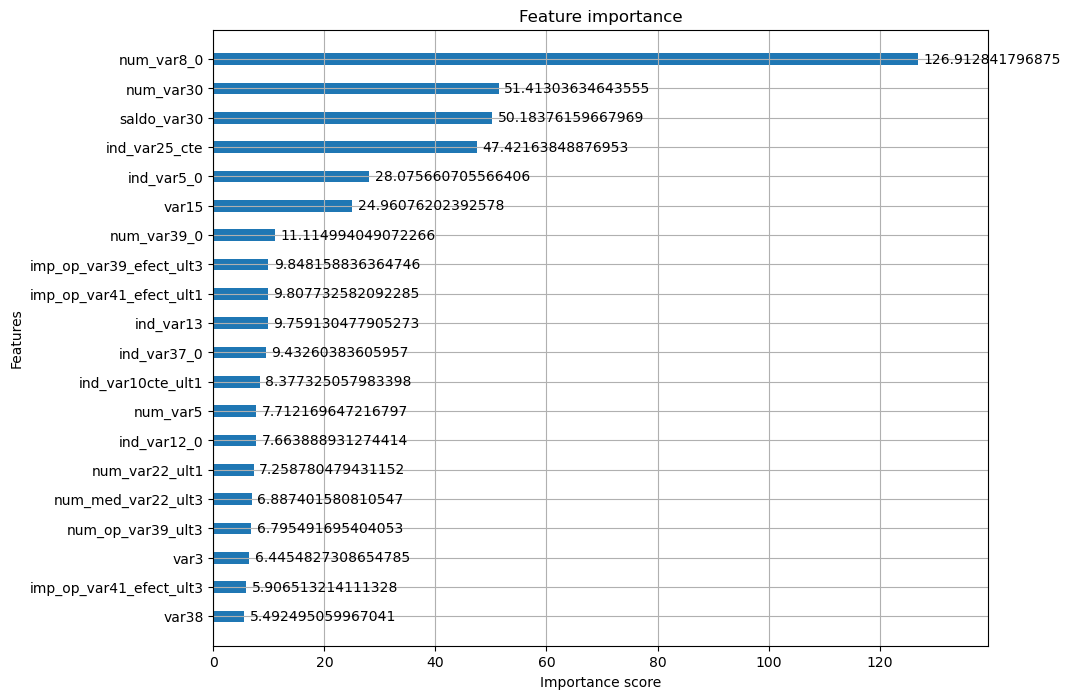

In [21]:
# 트리.importance로 시각화

fig, ax = plt.subplots(1,1, figsize=(10, 8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4, importance_type='gain')

In [22]:
xgb_clf.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], shape=(15204,))

L1 L2 파라미터 추가 

In [23]:
# best 값 확인인
best

{'colsample_bytree': np.float64(0.7182634686833416),
 'learning_rate': np.float64(0.17378359656337916),
 'max_depth': np.float64(5.0),
 'min_child_weight': np.float64(5.0)}

In [24]:
xgb_search_space = {'max_depth': hp.quniform('max_depth', 3, 9, 1),
                    'min_child_weight': hp.quniform('min_child_weight', 2, 8, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate': hp.uniform('learning_rate', 0.03, 0.11),
                    'reg_alpha': hp.uniform('reg_alpha', 0.01, 10),  # L1
                    'reg_lambda': hp.uniform('reg_lambda', 0.01, 10)  # L2                    
}

In [25]:
# 목적 함수 :  L1, L2 규제 추가
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=100, # 작게 설정함
                            max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            colsample_bytree=search_space['colsample_bytree'],
                            learning_rate=search_space['learning_rate'],
                            reg_alpha=search_space['reg_alpha'],
                            reg_lambda=search_space['reg_lambda'],
                            early_stopping_rounds=30,  # early stopping은 30회
                            eval_metric='auc',  # 평가 지표: auc
                            n_jobs=-1,
                            random_state=156
    )
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list= []
   
    # 3개 k-fold방식 적용
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train): # X_train : 6만건
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        # 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행.
        xgb_clf.fit(X_tr, y_tr,eval_set=[(X_tr, y_tr), (X_val, y_val)])
   
        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음.
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score) 
       
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환(AUC평균 점수가 가장 좋을때의 파라미터를 찾기위함)
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
    return -1 * np.mean(roc_auc_list)


In [26]:
trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수: 50회 하이퍼파라미터를 조합해 평가한다. 
            trials=trials, 
            rstate=np.random.default_rng(seed=30)) #fmin의 랜덤시드

print('best: ', best)

[0]	validation_0-auc:0.76129	validation_1-auc:0.73173 
[1]	validation_0-auc:0.83140	validation_1-auc:0.80441 
[2]	validation_0-auc:0.83809	validation_1-auc:0.81344 
[3]	validation_0-auc:0.84201	validation_1-auc:0.81898 
[4]	validation_0-auc:0.84763	validation_1-auc:0.82452 
[5]	validation_0-auc:0.84615	validation_1-auc:0.82276 
[6]	validation_0-auc:0.84879	validation_1-auc:0.82462 
[7]	validation_0-auc:0.84994	validation_1-auc:0.82602 
[8]	validation_0-auc:0.85215	validation_1-auc:0.82820 
[9]	validation_0-auc:0.85177	validation_1-auc:0.82762 
[10]	validation_0-auc:0.85364	validation_1-auc:0.82946
[11]	validation_0-auc:0.85518	validation_1-auc:0.82999
[12]	validation_0-auc:0.85596	validation_1-auc:0.83053
[13]	validation_0-auc:0.85537	validation_1-auc:0.82992
[14]	validation_0-auc:0.85580	validation_1-auc:0.83008
[15]	validation_0-auc:0.85660	validation_1-auc:0.83063
[16]	validation_0-auc:0.85619	validation_1-auc:0.82932
[17]	validation_0-auc:0.85621	validation_1-auc:0.82931
[18]	valid

In [27]:
# best(dict)로 다시 학습 예측 실행해봄 : 키값으로 가져옴
# n_estimators를 500증가 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행.
xgb_clf = XGBClassifier(
    n_estimators=500,
    learning_rate=round(best['learning_rate'], 5), # 소수점 이하 자리 반올림
    max_depth=int(best['max_depth']),
    min_child_weight=int(best['min_child_weight']),
    colsample_bytree=round(best['colsample_bytree'], 5),
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    early_stopping_rounds=100,  # 조기종료 
    eval_metric="auc",  # 평가 지표 
    random_state=156,
    n_jobs=-1  
)

# 학습 수행.
xgb_clf.fit(
    X_tr, y_tr,
    eval_set=[(X_tr, y_tr), (X_val, y_val)]
)

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.74210	validation_1-auc:0.72229
[1]	validation_0-auc:0.81968	validation_1-auc:0.80523
[2]	validation_0-auc:0.83086	validation_1-auc:0.81518
[3]	validation_0-auc:0.83613	validation_1-auc:0.81989
[4]	validation_0-auc:0.83974	validation_1-auc:0.82117
[5]	validation_0-auc:0.83909	validation_1-auc:0.82091
[6]	validation_0-auc:0.84217	validation_1-auc:0.82355
[7]	validation_0-auc:0.84382	validation_1-auc:0.82584
[8]	validation_0-auc:0.84443	validation_1-auc:0.82743
[9]	validation_0-auc:0.84495	validation_1-auc:0.82722
[10]	validation_0-auc:0.84648	validation_1-auc:0.82793
[11]	validation_0-auc:0.84713	validation_1-auc:0.82928
[12]	validation_0-auc:0.84835	validation_1-auc:0.83058
[13]	validation_0-auc:0.84844	validation_1-auc:0.83067
[14]	validation_0-auc:0.84899	validation_1-auc:0.83198
[15]	validation_0-auc:0.85015	validation_1-auc:0.83239
[16]	validation_0-auc:0.85049	validation_1-auc:0.83245
[17]	validation_0-auc:0.85099	validation_1-auc:0.83291
[18]	validation_0-au

---
light GBM



In [28]:
# base 모델
lgbm_clf=LGBMClassifier(
    n_estimators=500,
    early_stopping_rounds=100, 
    eval_metric='auc')
eval_set=[(X_tr,y_tr),(X_val,y_val)] # 학습, 검증 세팅
lgbm_clf.fit(X_tr, y_tr, eval_set=eval_set) # 학습

# 일반화 성능 확인
lgbm_roc_auc_score = roc_auc_score(
    y_test, lgbm_clf.predict_proba(X_test)[:,1]
)
print(f'AUC : {lgbm_roc_auc_score:.4f}')  # AUC : 0.8384

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13308
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 242
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training un

In [29]:
# 공간설정

lgbm_search_space = {'num_leaves': hp.quniform('num_leaves', 32, 64, 1),
                     'max_depth': hp.quniform('max_depth', 100, 160, 1),
                     'min_child_samples': hp.quniform('min_child_samples', 60, 100, 1),
                     'subsample': hp.uniform('subsample', 0.7, 1),# 각각의 스탭마다 사용할 샘플의 비율. 1 이하의 값= 오버 피팅 방지
                     'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
                    }


In [30]:
# 파라미터를 추가하여 함수를 수정
def objective_func(search_space):
    lgbm_clf =  LGBMClassifier(
        n_estimators=100, 
        num_leaves=int(search_space['num_leaves']), # 최대 리프갯수
        max_depth=int(search_space['max_depth']),
        min_child_samples=int(search_space['min_child_samples']), # 최소샘플갯수
        subsample=search_space['subsample'],
        learning_rate=search_space['learning_rate'],
        n_jobs=-1,
        early_stopping_rounds=30, # early stopping은 30회
        eval_metric="auc",  # 평가 지표: auc
        random_state=156
    )
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []
   
    # 3개 k-fold방식 적용
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

        # 학습과 검증 데이터로 XGBClassifier 학습 수행.
        lgbm_clf.fit(X_tr, y_tr, 
           eval_set=[(X_tr, y_tr), (X_val, y_val)])

        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음.
        score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)
   
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환(AUC평균 점수가 가장 좋을때의 파라미터를 찾기위함)
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
    return -1*np.mean(roc_auc_list)

In [31]:
trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func, space=lgbm_search_space, algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=30))


print('best:', best)

[LightGBM] [Warning] Unknown parameter: eval_metric   
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] Unknown parameter: eval_metric   
[LightGBM] [Info] Number of positive: 1579, number of negative: 38965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12827                    
[LightGBM] [Info] Number of data points in the train set: 40544, number of used features: 192
[LightGBM] [Warning] Unknown parameter: eval_metric   
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038945 -> initscore=-3.205872
[LightGBM] [Info] Start training from scor

In [32]:
# 일반화 성능 평가: best 파라미터 적용
lgbm_clf =  LGBMClassifier(
    n_estimators=500, num_leaves=int(best['num_leaves']),
    max_depth=int(best['max_depth']),
    min_child_samples=int(best['min_child_samples']),
    subsample=round(best['subsample'], 5),
    learning_rate=round(best['learning_rate'], 5),
    early_stopping_rounds=10, # 약한 학습기 개수 생각해서 적게줌
    eval_metric='auc',
    n_jobs=-1,
    random_state=156
)


# evaluation metric을 auc로, early stopping은 100 으로 설정하고 학습 수행.
lgbm_clf.fit(
    X_tr, y_tr,eval_set=[(X_tr, y_tr), (X_val, y_val)]
)


lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

# ROC AUC: 0.8409

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12898
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 192
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training until va

### L1, L2 규제 추가하기 

In [33]:
best  # lgbm의 파라미터

{'learning_rate': np.float64(0.060410380599969726),
 'max_depth': np.float64(122.0),
 'min_child_samples': np.float64(87.0),
 'num_leaves': np.float64(38.0),
 'subsample': np.float64(0.7023057985957527)}

In [34]:
# 베스트를 참고하여 범위를 약간 줄임

lgbm_search_space = {
                    'num_leaves': hp.quniform('num_leaves', 33, 45, 1),
                    'max_depth': hp.quniform('max_depth', 110, 140, 1),
                    'min_child_samples': hp.quniform('min_child_samples', 70, 95, 1),
                    'subsample': hp.uniform('subsample', 0.5, 0.8),# 각각의 스탭마다 사용할 샘플의 비율. 1 이하의 값= 오버 피팅 방지
                    'learning_rate': hp.uniform('learning_rate', 0.03, 0.1),
                    'reg_alpha': hp.uniform('reg_alpha', 0.01, 10),  # L1 정규화
                    'reg_lambda': hp.uniform('reg_lambda', 0.01, 10)  # L2 정규화
                    }


In [35]:
# L1, L2 파라미터를 추가하여 함수를 수정
def objective_func(search_space):
    lgbm_clf =  LGBMClassifier(
        n_estimators=100, 
        num_leaves=int(search_space['num_leaves']), # 최대 리프갯수
        max_depth=int(search_space['max_depth']),
        min_child_samples=int(search_space['min_child_samples']), # 최소샘플갯수
        subsample=search_space['subsample'],
        learning_rate=search_space['learning_rate'],
        reg_alpha=search_space['reg_alpha'],  # L1 정규화
        reg_lambda=search_space['reg_lambda'],  # L2 정규화
        n_jobs=-1,
        early_stopping_rounds=30, # early stopping은 30회
        eval_metric="auc",  # 평가 지표: auc
        random_state=156
    )
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []
   
    # 3개 k-fold방식 적용
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

        # 학습과 검증 데이터로 XGBClassifier 학습 수행.
        lgbm_clf.fit(X_tr, y_tr, 
           eval_set=[(X_tr, y_tr), (X_val, y_val)])

        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음.
        score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)
   
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환(AUC평균 점수가 가장 좋을때의 파라미터를 찾기위함)
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
    return -1*np.mean(roc_auc_list)

In [36]:
trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func, 
            space=lgbm_search_space, 
            algo=tpe.suggest,
            max_evals=50, # 최대 50회 반복
            trials=trials, 
            rstate=np.random.default_rng(seed=30))

print('best:', best)

[LightGBM] [Warning] Unknown parameter: eval_metric   
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] Unknown parameter: eval_metric   
[LightGBM] [Info] Number of positive: 1579, number of negative: 38965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12885                    
[LightGBM] [Info] Number of data points in the train set: 40544, number of used features: 197
[LightGBM] [Warning] Unknown parameter: eval_metric   
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038945 -> initscore=-3.205872
[LightGBM] [Info] Start training from scor

In [37]:
# 일반화 성능 평가: best 파라미터 적용
lgbm_clf =  LGBMClassifier(
    n_estimators=500, num_leaves=int(best['num_leaves']),
    max_depth=int(best['max_depth']),
    min_child_samples=int(best['min_child_samples']),
    subsample=round(best['subsample'], 5),
    learning_rate=round(best['learning_rate'], 5),
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    early_stopping_rounds=50, # 약한 학습기 개수 
    eval_metric='auc',
    n_jobs=-1,
    random_state=156
)


# evaluation metric을 auc로, early stopping은 100 으로 설정하고 학습 수행.
lgbm_clf.fit(
    X_tr, y_tr,eval_set=[(X_tr, y_tr), (X_val, y_val)]
)


lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 195
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training until validation scores don't improve for 50 rounds
Early stopping, best